# Machine learning lab 5 - Arailym Kaiyrova

### Exercise 1: Backward search for variable selection

In [425]:
import numpy as np
import math
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import random
random.seed(3116)

First loaded data, and dropped rows with NA values

In [647]:
df = pd.DataFrame(pd.read_csv('bank.csv', delimiter = ";"))
df = df.dropna()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


To convert non-numeric columns to numeric, I have used different approach for each column.\
For month columns, intead of creating 12 columns with one-hot encoding, I mapped the values to number of month according to pre-created dictionary hash-map dictionary 'month-labels'.\
Next, columns 'default', 'housing', 'loan', and 'y' contain values 'yes' or 'no'. For these columns, I have replaces all 'yes' values to 1, and 'no' values to 0.\
Other non-numeric columns 'job','marital', 'education', 'contact', 'poutcome' were one-hot encoded using pandas get_dummies function.

In [648]:
month_labels = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 
                'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

df['month'] = df['month'].apply(lambda x: month_labels[x])

df.iloc[:, :].replace({"yes": 1, "no": 0}, inplace=True)
df = pd.get_dummies(df, columns = ['job','marital', 'education', 'contact', 'poutcome'])
df.head()

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,30,0,1787,0,0,19,10,79,1,-1,...,0,0,0,1,0,0,0,0,0,1
1,33,0,4789,1,1,11,5,220,1,339,...,1,0,0,1,0,0,1,0,0,0
2,35,0,1350,1,0,16,4,185,1,330,...,0,1,0,1,0,0,1,0,0,0
3,30,0,1476,1,1,3,6,199,4,-1,...,0,1,0,0,0,1,0,0,0,1
4,59,0,0,1,0,5,5,226,1,-1,...,1,0,0,0,0,1,0,0,0,1


Data was normalized according to normal distribuition, except target column. I wanted to leave target column as 1, and 0.

In [649]:
target = df['y']
normalized_df=(df-df.mean())/df.std()
normalized_df['y'] = target
normalized_df.head()

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,-1.056153,-0.130744,0.121058,-1.141925,-0.424709,0.374011,1.611695,-0.711782,-0.576766,-0.407173,...,-1.020222,-0.652410,-0.207696,0.748996,-0.267042,-0.643465,-0.348613,-0.213423,-0.171362,0.469249
1,-0.772497,-0.130744,1.118521,0.875521,2.354032,-0.595961,-0.490576,-0.169175,-0.576766,2.988713,...,0.979962,-0.652410,-0.207696,0.748996,-0.267042,-0.643465,2.867876,-0.213423,-0.171362,-2.130595
2,-0.583394,-0.130744,-0.024142,0.875521,-0.424709,0.010271,-0.911031,-0.303865,-0.576766,2.898822,...,-1.020222,1.532439,-0.207696,0.748996,-0.267042,-0.643465,2.867876,-0.213423,-0.171362,-2.130595
3,-1.056153,-0.130744,0.017724,0.875521,2.354032,-1.565932,-0.070122,-0.249989,0.387925,-0.407173,...,-1.020222,1.532439,-0.207696,-1.334826,-0.267042,1.553743,-0.348613,-0.213423,-0.171362,0.469249
4,1.685850,-0.130744,-0.472701,0.875521,-0.424709,-1.323439,-0.490576,-0.146086,-0.576766,-0.407173,...,0.979962,-0.652410,-0.207696,-1.334826,-0.267042,1.553743,-0.348613,-0.213423,-0.171362,0.469249


Then data was splitted into train, and test sets accoring to given ratio 0.8

In [650]:
def split_train_test(df, frac):
    train=df.sample(frac=frac,random_state=200) #random state is a seed value
    test=df.drop(train.index)
    return train, test

train, test = split_train_test(normalized_df, 0.8)
train.head()

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
3825,-0.867049,7.646823,-0.471372,0.875521,2.354032,1.101489,0.770786,-0.507823,1.674178,-0.407173,...,0.979962,-0.652410,-0.207696,0.748996,-0.267042,-0.643465,-0.348613,-0.213423,-0.171362,0.469249
3936,-0.677946,-0.130744,0.540710,0.875521,-0.424709,-0.353468,-0.490576,0.789046,-0.576766,-0.407173,...,-1.020222,1.532439,-0.207696,0.748996,-0.267042,-0.643465,-0.348613,-0.213423,-0.171362,0.469249
2826,-0.205186,-0.130744,-0.219182,0.875521,-0.424709,-0.595961,-0.490576,2.359142,1.352615,2.599185,...,-1.020222,1.532439,-0.207696,0.748996,-0.267042,-0.643465,-0.348613,4.684483,-0.171362,-2.130595
1503,1.402195,-0.130744,-0.510247,0.875521,2.354032,-0.474714,0.770786,1.347046,-0.255202,-0.407173,...,0.979962,-0.652410,-0.207696,0.748996,-0.267042,-0.643465,-0.348613,-0.213423,-0.171362,0.469249
748,-0.583394,-0.130744,0.405478,-1.141925,2.354032,-0.959700,0.350332,-0.019092,-0.576766,-0.407173,...,-1.020222,-0.652410,-0.207696,0.748996,-0.267042,-0.643465,-0.348613,-0.213423,-0.171362,0.469249


Next, data was divided into input and target components

In [69]:
def return_data_components(trainset, testset, target):
    return trainset.drop([target], axis=1).to_numpy(),\
            trainset[target].to_numpy(),\
            testset.drop([target], axis=1).to_numpy(),\
            testset[target].to_numpy()    

train_x, train_y, test_x, test_y = return_data_components(train, test, 'y')

array([[-0.86704919,  7.64682322, -0.47137156, ..., -0.2134235 ,
        -0.17136245,  0.46924855],
       [-0.67794555, -0.13074433,  0.54071025, ..., -0.2134235 ,
        -0.17136245,  0.46924855],
       [-0.20518644, -0.13074433, -0.21918177, ...,  4.68448328,
        -0.17136245, -2.13059543],
       ...,
       [-0.29973826, -0.13074433, -0.45210014, ..., -0.2134235 ,
        -0.17136245,  0.46924855],
       [-0.58339373, -0.13074433, -0.41023464, ..., -0.2134235 ,
        -0.17136245,  0.46924855],
       [-1.05615283, -0.13074433, -0.47270062, ..., -0.2134235 ,
        -0.17136245,  0.46924855]])

Next, to implemet Gradient ascent algorithm, we need few components that will be necessary while learning a model\
\
First, 'likelihood' function below calculates the Likelihood for given input, target, and current values of theta.\
Also, while calculating the likelihood, it also calculates prediction values of Y (sigmoid function), and gradient of likelihood function for current theta.

In [467]:
def likelihood(X, Y, teta):
    L = 0
    grad = np.zeros(len(teta))
    Y_PRED = np.zeros(len(Y))
    for i in range(len(Y)):
        x_teta = np.sum(np.matmul(X[i,:].T, teta))
        z = Y[i]*x_teta - np.log(1+math.exp(x_teta))
        Y_PRED[i]+=(1/(1+math.exp(-x_teta)))
        L+=z
        grad = np.add(grad, X[i,:]*(Y[i] - Y_PRED[i]))
    return L, Y_PRED, grad

Next, funtion 'logLoss' below calculates logarithmic loss function for predicted sigmoid function values. This logLoss function is used for measuring error for log functions, instead of RMSE in linear regression:

In [651]:
def logLoss(X, Y, teta):
    loss = 0
    for i in range(len(Y)):
        x_teta = np.sum(np.matmul(X[i,:].T, teta))
        y_pred = 1/(1+math.exp(-x_teta))
        z = -Y[i]*np.log(y_pred) - (1-Y[i])*np.log(1-y_pred)
        loss+=z
    return loss/len(Y)  

Next main step is implementing Stochastic gradient descent (ascent for logistic regression) method.\
\
Stochastic gradient descent first shuffles data, and during each iteration takes one data row for training.\
During each iteration, theta value is updated accoring to given learning rate and local gradient of selected data row.\

Then returns latest updated theta values, and log likelihood value for train data with this theta, and log loss value

In [653]:
def SGD2(X_train, Y_train, i_max, X_test, Y_test, r):
    l = list(range(len(Y_train)))
    random.shuffle(l)
    
    #Initialize teta
    teta = [0]*X_train.shape[1]
    for i in range(i_max):
        z = l[i]
        
        #Gradient of loss function
        x_teta = np.sum(np.matmul(X_train[i,:].T, teta))
        grad = X_train[z,:]*(Y_train[z] - (1/(1+math.exp(-x_teta))))

        #Updating model parameters
        teta = np.add(teta, r*grad)
    return teta, likelihood(X_train, Y_train, teta)[0], logLoss(X_train, Y_train, teta)

Backward search algorithm\
Backward search takes all feature columns available in the dataset, caluclates its AIC value, and drops each column, and calculates its AIC, if dropping specific column leads to the decrease in AIC in comparison with dropping other columns, then removes this column from feature columns, and this process continues until there is no improvement in AIC minimization.\

Then function return final list of selected columns

In [654]:
#Backward Search for parameter selection
def backward_search(Xtrain, Ytrain, Xvalid, Yvalid):   
    i_max, rate = 200, 0.001
    
    V_used = np.ones((Xtrain.shape[0],1))
    V_used = np.column_stack((V_used,Xtrain))
    V_val = np.ones((Xvalid.shape[0],1))
    V_val = np.column_stack((V_val,Xvalid))
    
    feature_columns = list(range(Xtrain.shape[1]+1))
    
    improvement = True
    while improvement:
        gain_best = 0
        v_best = None
        
        #Current log likelihood
        l_curr = SGD2(V_used, Ytrain, i_max, V_val, Yvalid, rate)[1]
        AIC2 = (-2*l_curr)+(2*(V_used.shape[1]-1))
        print('current best AIC:', AIC2)
        for i in range(1, V_used.shape[1]):
            #Log and AIC likelihood when removing one column vector
            l1 = SGD2(np.delete(V_used, i, 1), Ytrain, i_max, np.delete(V_val, i, 1), Yvalid, rate)[1]
            AIC1 = (-2*l1)+(2*(V_used.shape[1]-2))
        
            gain = AIC1 - AIC2
            if gain<gain_best:
                gain_best = gain
                v_best = i

        improvement = gain_best<0
        if improvement:
            V_used = np.delete(V_used, v_best, 1)
            V_val = np.delete(V_val, v_best, 1)
            print(feature_columns[v_best], 'th column was removed from the model input')
            del feature_columns[v_best]
    
    print('Final feature columns left:', feature_columns)
    return V_used, V_val

In [655]:
V_used, V_val = backward_search(train_x, train_y, test_x, test_y)

current best AIC: 4839.03425173886
21 th column was removed from the model input
current best AIC: 4831.114834525104
8 th column was removed from the model input
current best AIC: 4837.075652913989
14 th column was removed from the model input
current best AIC: 4863.972283718611
18 th column was removed from the model input
current best AIC: 4849.214622417441
15 th column was removed from the model input
current best AIC: 4831.779103711315
17 th column was removed from the model input
current best AIC: 4833.829150743909
11 th column was removed from the model input
current best AIC: 4819.02350981472
9 th column was removed from the model input
current best AIC: 4837.255794220682
22 th column was removed from the model input
current best AIC: 4835.772008925512
29 th column was removed from the model input
current best AIC: 4849.070581608061
32 th column was removed from the model input
current best AIC: 4818.352127057301
6 th column was removed from the model input
current best AIC: 483

Above, it can be seen how columns started dropping one by one until no improvement.\
In the end, 19 columns left out of 37 initially available columns.\
Also, test erro was calculated for cases when columns were not dropped, and after they were exculded, and the dropping the columns leads to the decrease in test log loss, which is 0.66446


In [668]:
i_max, rate = 200, 0.001
print('After backward search algorithm',V_used.shape[1]-1, 'feature columns left out of ', train_x.shape[1], 'columns')

theta_before = SGD2(train_x, train_y, i_max, train_y, test_y, rate)[0]
test_error_before = logLoss(test_x, test_y, theta_before)

theta = SGD2(V_used, train_y, i_max, V_val, test_y, rate)[0]
test_error = logLoss(V_val, test_y, theta)

print('The log loss on test error value before dropping the columns: ', test_error_before)
print('The log loss on test error value after dropping the columns: ', test_error)

After backward search algorithm 19 feature columns left out of  37 columns
The log loss on test error value before dropping the columns:  0.6873505034872935
The log loss on test error value after dropping the columns:  0.6644599645572246


### Exercise 2: Regularization for Logistic Regression

Stochastic gradient ascent (SDA) function that was used for this task is similar to the SDA from Exercise1. Only difference is that is adds regularization according to the given value of lambda which also changes the value of calculated gradient.\
\
It then returns, log loss for both trainset, and testset according to latest updated model parameters

In [633]:
def SGD_regularization(X_train, Y_train, i_max, X_test, Y_test, r, lambd):
    #Initialize teta
    teta = [0]*X_train.shape[1]
    for i in range(i_max):
        z = i
        
        #Gradient of likelihood function
        x_teta = np.sum(np.matmul(X_train[z,:].T, teta))
        grad = X_train[z,:]*(Y_train[z] - (1/(1+math.exp(-x_teta)))) - 2*lambd*np.array(teta)

        #Updating model parameters
        teta = np.add(teta, r*grad)
        
    return teta, logLoss(X_train, Y_train, teta), logLoss(X_test, Y_test, teta)

The next function 'cross_val_split' takes the values of X, and Y, and divides data into K chunks, and returns k-th chunk as testset, rest data se trainset.

In [673]:
# Input: instances X, labels y, number of cross-validation folds K, current fold k
# Output: train and test sets for fold k
def crossval_split(X,y,K,k):
    # your code here...
    step = math.ceil(len(y)/K)
    start = k*step
    end = len(y) if (k+1)*step>len(y) else (k+1)*step
    return np.vstack((X[:start], X[end:])), np.hstack((y[:start], y[end:])), X[start:end,:], y[start:end]

The next function performns K-cross validation for given values of learning rate and lambda, calculates train and test error for each k, then returns their average

In [676]:
#Cross validation for given values of learning rate and lambda
def cross_val_for_r_lambd(X, Y, K, r, lambd):
    rmse = []
    rmse_test = []
    for k in range(K):
        X_train, y_train, X_test, y_test = crossval_split(X,Y,K,k)
        # Fit regression without regularization
        theta, train_error, test_error = SGD_regularization(X_train, y_train, 200, X_test, y_test, r, lambd)
        rmse.append(train_error)
        rmse_test.append(test_error)
    return np.sum(rmse)/K, np.sum(rmse_test)/K

K value was selected as 5, and list different lambda, and learning rate values were initialized.\
Then for each combination of lambda, and learning rate, their classification accurasy scores (1-log loss) for train and test data were calculated and stored in 'average_results' array:

In [687]:
K = 5
lambdas = [1, 0.1, 0.01, 0.001]
rates = [0.01, 0.001, 0.0001, 0.0001]

X, Y = normalized_df.drop(['y'], axis=1).to_numpy(), normalized_df['y'].to_numpy()

average_results = []

for lambd in lambdas:
    for r in rates:
        err_train, err_test = cross_val_for_r_lambd(X, Y, K, r, lambd)
        average_results.append([r, lambd, 1-err_train, 1-err_test])
        print('Average train error for logistic regression for lambda', lambd, 'rate', r, 'is', err_train)
        print('Average test error for logistic regression for lambda', lambd, 'rate', r, 'is', err_test)

Average train error for logistic regression for lambda 1 rate 0.01 is 0.683077512447111
Average test error for logistic regression for lambda 1 rate 0.01 is 0.6823897327688675
Average train error for logistic regression for lambda 1 rate 0.001 is 0.6871747499166052
Average test error for logistic regression for lambda 1 rate 0.001 is 0.687846897155716
Average train error for logistic regression for lambda 1 rate 0.0001 is 0.6923703212821702
Average test error for logistic regression for lambda 1 rate 0.0001 is 0.6924647978621867
Average train error for logistic regression for lambda 1 rate 0.0001 is 0.6923703212821702
Average test error for logistic regression for lambda 1 rate 0.0001 is 0.6924647978621867
Average train error for logistic regression for lambda 0.1 rate 0.01 is 0.6700777304679849
Average test error for logistic regression for lambda 0.1 rate 0.01 is 0.6733352704260906
Average train error for logistic regression for lambda 0.1 rate 0.001 is 0.686204605547559
Average test

Results:\
The final results are given below as pandas dataframe, and after sorting the rows according to the train eacc, it can be seen that combination of learning rate = 0.01 and lambda 0.001 gives the highest train accuracy:

In [690]:
df_results_cv = pd.DataFrame(average_results, columns = ['learning rate', 'lambda', 'train_acc', 'test_acc'])
df_results_cv.sort_values(by=['train_acc'], ascending = False)

,learning rate,lambda,train_acc,test_acc
12,0.0100,0.001,0.331560,0.327133
8,0.0100,0.010,0.331433,0.327125
4,0.0100,0.100,0.329922,0.326665
0,0.0100,1.000,0.316922,0.317610
13,0.0010,0.001,0.313914,0.313020
9,0.0010,0.010,0.313903,0.313012
5,0.0010,0.100,0.313795,0.312927
1,0.0010,1.000,0.312825,0.312153
14,0.0001,0.001,0.307644,0.307547
15,0.0001,0.001,0.307644,0.307547


Plot on the grid α0 vs λ the Classification Accuracy score for all combinations.\
Here, for convenience, for x and y axes which is for lambda and learning rate values, instead of their values, I used degrees that was applied on 0.1 to achiev the value of lambda, or learning rate.\
For example d=2 for lamda means lamda = (0.1)^2 = 0.01. etc.\
From the plot, it can be seen that highest accuracy is achieved when lambda = (0.1)^3 and rate = (0.1)^2

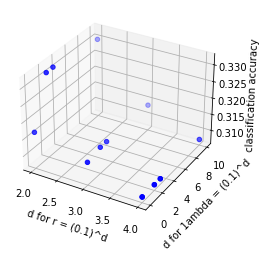

In [693]:
df_results_cv.iloc[:, :].replace({1: 0, 0.1: 10, 0.01:2, 0.001:3, 0.0001:4}, inplace=True)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(df_results_cv['learning rate'], df_results_cv['lambda'], df_results_cv['train_acc'], color = 'b')
ax.set_xlabel('d for r = (0.1)^d')
ax.set_ylabel('d for 1ambda = (0.1)^d')
ax.set_zlabel('classification accuracy')

plt.show()

Then, model was trained using the selected best hyperparameters, los loss error for test set was calculated, as can be seen below:

In [697]:
best_rate, best_lambda = 0.01, 0.001
theta_best, train_error, test_error = SGD_regularization(train_x, train_y, 200, test_x, test_y, best_rate, best_lambda)
print('The log loss error on trainset for best selected hyperparameters lambda', best_lambda, 'learning rate', best_rate, 'is', train_error)
print('The log loss error on testset for best selected hyperparameters lambda', best_lambda, 'learning rate', best_rate, 'is', test_error)

The log loss error on trainset for best selected hyperparameters lambda 0.001 learning rate 0.01 is 0.6635504155331445
The log loss error on testset for best selected hyperparameters lambda 0.001 learning rate 0.01 is 0.6833727956939923


Plot on the grid α0 vs λ the Classification Accuracy score of both train and test datasets for all combinations.\
Blue color shows train accuracy, and red color shows test accuracy.\

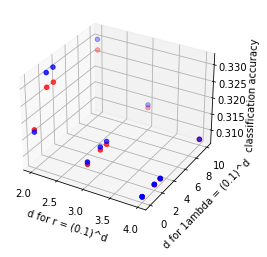

In [695]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(df_results_cv['learning rate'], df_results_cv['lambda'], df_results_cv['train_acc'], color = 'b')
ax.scatter(df_results_cv['learning rate'], df_results_cv['lambda'], df_results_cv['test_acc'], color = 'r')
ax.set_xlabel('d for r = (0.1)^d')
ax.set_ylabel('d for 1ambda = (0.1)^d')
ax.set_zlabel('classification accuracy')

plt.show()

## Exercise 3: Implementing Hyperband for Logistic Regression

In this task, as hyperparameters lambda value, learning rate, and batch size were used. Configs array below stores all possible (lambda, lr, batch size) combinations. 4 options for lambda, 4 for lr, and 4 for bact size, and in total gives 4x4x4 = 64 combinations.\
\
'get_random_hyperparameter_configuration' below return randomly returns one of these combinations when called.

In [699]:
configs = []
lambdas = [1, 0.1, 0.01, 0.001]
rates = [0.01, 0.001, 0.0001, 0.0001]
batch_sizes = [50, 100, 500, 1000]

for lambd in lambdas:
    for r in rates:
        for s in batch_sizes:
            configs.append((lambd,r,s))
            
print(len(configs))
        
def get_random_hyperparameter_configuration():
    i = random.randint(0, len(configs)-1)
    return configs[i]

64


'create_mini_batches' divides dataset into multiple data chunks each chunk containing data of size 'batch_size'

In [700]:
def create_mini_batches(X, y, batch_size):
    batches = []
    data = np.hstack((X, y))
    np.random.shuffle(data)
    batch_count = data.shape[0] // batch_size
    i = 0
  
    for i in range(batch_count + 1):
        curr_batch = data[i * batch_size:(i + 1)*batch_size, :]
        X_curr, Y_curr = curr_batch[:, :-1], curr_batch[:, -1].reshape((-1, 1))
        batches.append((X_curr, Y_curr))
    
    if data.shape[0] % batch_size != 0:
        curr_batch = data[i * batch_size:data.shape[0]]
        X_curr, Y_curr = curr_batch[:, :-1], curr_batch[:, -1].reshape((-1, 1))
        batches.append((X_curr, Y_curr))
    return batches

This SGD is similar to other SGDs implemeted in previous tasks, except intead of one data row, it trains collection of data of size 'batch_size', and returns theta, and log loss for test set(validation set):

In [701]:
def SGD_batches(X, Y, i_max, X_test, Y_test, r, lambd, batch_size):
    batches = create_mini_batches(X, Y.reshape((len(Y), 1)), batch_size)
    #Initialize teta
    teta = [0]*X.shape[1]
    for i in range(min(i_max, len(batches))):  
        X_train, Y_train = batches[i]
        L, Y_PRED, grad = likelihood(X_train, Y_train, teta) 
        #Gradient of loss function
        #Updating model parameters
        teta = np.add(teta, r*grad)
    return teta, logLoss(X_test, Y_test, teta)

Hyperband implemetation:\
Prototype of the algorithm was taken from https://homes.cs.washington.edu/~jamieson/hyperband.html that was provided in Exercise Sheet 5. \
\
At each outerloop, for taking random hyperparameter configurations, 'get_random_hyperparameter_configuration()' method explained above was used.\
\
Then for trainig, and calculating validation log loss, also the function 'SGD_batches' explained above were used.\
\
Also, data was resplitted into train, validation, and test set accorting to ratio, 0.7, 0.15, 0.15:

In [708]:
train, test_val = split_train_test(normalized_df, 0.7)
val, test = split_train_test(test_val, 0.5)


train_x_hb, train_y_hb = train.drop(['y'], axis=1).to_numpy(), train['y'].to_numpy()
test_x_hb, test_y_hb = test.drop(['y'], axis=1).to_numpy(), test['y'].to_numpy() 
val_x_hb, val_y_hb = val.drop(['y'], axis=1).to_numpy(), val['y'].to_numpy() 

max_iter = 81  # maximum iterations/epochs per configuration
eta = 3 # defines downsampling rate (default=3)
s_max = int(np.log(max_iter)/np.log(eta))
B = (s_max+1)*max_iter  # total number of iterations (without reuse) per execution of Succesive Halving (n,r)

best_results = []

# Begin Finite Horizon Hyperband outlerloop. Repeat indefinetely.
for s in reversed(range(s_max+1)):
    n = int(math.ceil(int(B/max_iter/(s+1))*eta**s)) # initial number of configurations
    r = max_iter*eta**(-s) # initial number of iterations to run configurations for

    # Begin Finite Horizon Successive Halving with (n,r)
    T = [ get_random_hyperparameter_configuration() for i in range(n) ] 
    for i in range(s+1):
        # Run each of the n_i configs for r_i iterations and keep best n_i/eta
        n_i = n*eta**(-i)
        r_i = r*eta**(i)
 
        val_losses = [ (SGD_batches(train_x_hb, train_y_hb, int(r_i), val_x_hb, val_y_hb, r, lambd, b_size)[1], (lambd, r, b_size)) for lambd, r, b_size in T ]
        val_losses = sorted(val_losses, key=lambda tup: tup[0])[:int( n_i/eta )]
        T = [t[1] for t in val_losses]
        if i==s-1: 
            best_results+=val_losses

According to the results below, best hyperparameter combination for lambda, learning rate, batch size is (0.001, 0.001, 1000)

In [709]:
print(best_results)
best_parameter_combination, best_error = None, float('inf')
for err, params in best_results:
    if err<best_error: best_parameter_combination, best_error = params, err

print('Best parameter combination for lambda, learning rate, batch size: ',best_parameter_combination)
print('It gives error: ',best_error)
        

[(0.6510977368839228, (0.001, 0.001, 1000)), (0.6515426233964906, (0.1, 0.001, 1000)), (0.6582030785189236, (0.001, 0.001, 1000)), (0.6577289889224349, (1, 0.001, 100)), (0.6727937317085969, (1, 0.01, 100))]
Best parameter combination for lambda, learning rate, batch size:  (0.001, 0.001, 1000)
It gives error:  0.6510977368839228


Finally, SGD was trained again according to obtained best hyperparameters, and test log loss was calculated for trained model parameters theta:

In [710]:
theta_hb, val_loss = SGD_batches(train_x_hb, train_y_hb, 200, val_x_hb, val_y_hb, best_parameter_combination[1], best_parameter_combination[0], best_parameter_combination[2])
test_loss = logLoss(test_x_hb, test_y_hb, theta_hb)
print('Log loss on test data is: ',test_error)

Log loss on test data is:  0.6833727956939923
